# First attempt with keras/tf

In [70]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.core.debugger import set_trace as st

print(tf.__version__)

1.10.0


## Dataset: ISO-SWS

In [71]:
# Needed directories
base_dir = '../data/isosws_atlas/'

# Pickles containing our spectra in the form of pandas dataframes:
spec_dir = base_dir + 'spectra/'
spec_files = np.sort(glob.glob(spec_dir + '*.pkl'))

# Metadata pickle (pd.dataframe). Note each entry contains a pointer to the corresponding spectrum pickle.
metadata = base_dir + 'metadata.pkl'

In [72]:
# Load the metadata pickle.
meta = pd.read_pickle(metadata)

In [75]:
meta

,object_name,tdt,ra,dec,full_classifier,group,subgroup,uncertainty_flag,note,,file_path,object_type,data_ok
0,W Cet,37802225,0.532083,-14.676639,2.SEa:,2,SEa,1,,,spectra/37802225_sws.pkl,S*,True
1,SV And,42801007,1.083333,40.110333,2.SEa:,2,SEa,1,,,spectra/42801007_sws.pkl,Mira,True
2,SV And,80800708,1.083333,40.110333,2.SEa,2,SEa,,,,spectra/80800708_sws.pkl,Mira,True
3,CIT 1,78201008,1.717917,43.076667,7,7,,,W,,spectra/78201008_sws.pkl,Mira,True
4,HR 10,37802001,1.825833,-17.387000,1.NM:,1,NM,1,,,spectra/37802001_sws.pkl,Star,True
5,{beta} Cas,28501420,2.293625,59.149944,1.N,1,N,,,,spectra/28501420_sws.pkl,Star,True
6,V633 Cas,43501514,2.860833,58.834444,5.SE,5,SE,,W,,spectra/43501514_sws.pkl,Ae*,True
7,NGC 40,44401917,3.253792,72.522222,4.PN,4,PN,,,,spectra/44401917_sws.pkl,PN,True
8,NGC 40,30003803,3.254583,72.521972,4.PN,4,PN,,,,spectra/30003803_sws.pkl,PN,True
9,HR 48,55502138,3.660000,-18.932889,1.NO,1,NO,,,,spectra/55502138_sws.pkl,Candidate_LP*,True


### Labels

In [76]:
# Simple classifier first.
labels = meta['group'].values.astype(int)

In [77]:
# The possible labels.
np.unique(labels)

array([1, 2, 3, 4, 5, 6, 7])

#### Labels ('group'):

1. Naked stars
2. Stars with dust
3. Warm, dusty objects
4. Cool, dusty objects
5. Very red objects
6. Continuum-free objects but having emission lines
7. Flux-free and/or fatally flawed spectra

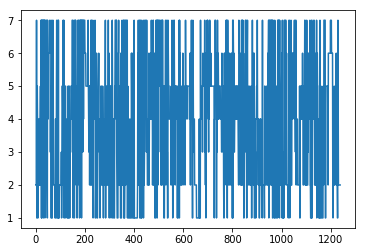

In [90]:
# See how the labels are distributed.
plt.plot(labels);

In [91]:
# Shuffle data at some point.

In [78]:
type(labels[0])

numpy.int64

In [79]:
# Make sure each sample has a valid label.
np.sum(np.isfinite(labels)) == len(labels)

True

In [80]:
len(labels)

1239

In [81]:
# knowing that each sample has a 359-point vector/spectrum.
spectra = np.zeros((len(labels), 359))

### Spectra

In [84]:
def load_spectrum(path):
    df = pd.read_pickle(path)
    return df['flux']

index = 0
# Fill the 'spectra' variable with the astronomical data.
for row in meta.itertuples(index=True, name='Pandas'):
    flux = load_spectrum(base_dir + row.file_path)
    spectra[index] = flux
    index += 1

In [83]:
spectra.shape

(1239, 359)

# Split into training and test

Data as...
- spectra (1239, 359)
- labels (1239)